**Task**: Given an image of a fashion item, build a deep learning model that recognizes the fashion item.

In [126]:
import pandas as pd
import numpy as np
import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

import keras_tuner as kt

# Functions

In [16]:
def plot_image(image, label):
    plt.imshow(image, cmap = plt.cm.binary)
    plt.xlabel(label)

In [17]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [18]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


In [147]:
def plot_confusion_matrix(df_cm,name_plot):    
    index = df_cm.index
    index.name = "Actual"

    columns= df_cm.columns
    columns.name = "Predict"

    plt.figure(figsize = (12,9))

    # by default number in float .2 : fmt=.2g, but we want eg.789
    sns.heatmap(df_cm/np.sum(df_cm), annot=True,fmt='.1%',
               cmap=sns.color_palette("crest", as_cmap=True))

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.title(name_plot+': Confusion Matrix with percentage %')

    #Rotating axis labels
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
    )

    plt.show()

# Global values

In [20]:
number_of_classes = 10
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Set the Numpy and Tensorflow seed so that stochasticity in repeated experimentation is removed and results are reproducible, especially when performing hyperparameter tuning.

In [21]:
random_seed = 547654
np.random.seed(random_seed)
set_seed = random_seed

# Data exploratory analysis

In [58]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [59]:
# DEV data for hypertuning
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(
    x_train, 
    y_train, 
    test_size = 0.2, 
    stratify = y_train, 
    random_state = random_seed, 
    shuffle = True
)

In [60]:
print("X_train shape -> ", X_train.shape)
print("X_dev shape -> ", X_dev.shape)
print("x_test shape -> ", x_test.shape)
print("")
print("Y_train shape -> ", Y_train.shape)
print("Y_dev shape -> ", Y_dev.shape)
print("y_test shape -> ", y_test.shape)

X_train shape ->  (48000, 28, 28)
X_dev shape ->  (12000, 28, 28)
x_test shape ->  (10000, 28, 28)

Y_train shape ->  (48000,)
Y_dev shape ->  (12000,)
y_test shape ->  (10000,)


### Data Visualizations

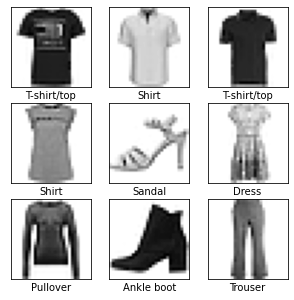

In [25]:
plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plot_image(X_train[i], class_labels[Y_train[i]])

In [26]:
sns.set_theme(style="darkgrid")

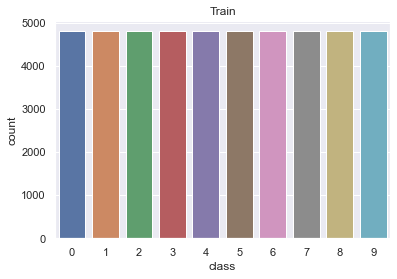

In [27]:
ax = sns.countplot(x="class", data=pd.DataFrame({'class':Y_train}))
_ = ax.set_title('Train')

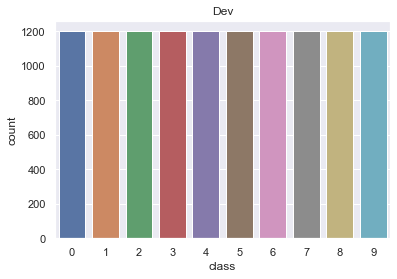

In [28]:
ax = sns.countplot(x="class", data=pd.DataFrame({'class':Y_dev}))
_ = ax.set_title('Dev')

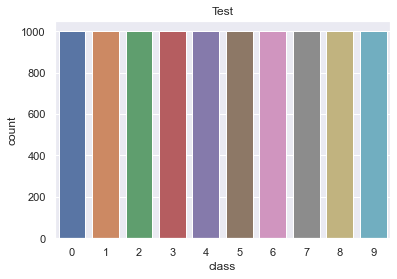

In [29]:
ax = sns.countplot(x="class", data=pd.DataFrame({'class':y_test}))
_ = ax.set_title('Test')

In [61]:
Y_train = to_categorical(Y_train, number_of_classes)
Y_dev = to_categorical(Y_dev, number_of_classes)
Y_test = to_categorical(y_test, number_of_classes)

# MLP

The data are grayscale 28*28 images of fashion item. Since we will use an MLP to classify them, we first need to flatten them

In [62]:
X_train_mlp = X_train.reshape(48000, 784)
X_dev_mlp = X_dev.reshape(12000, 784)
X_test_mlp = x_test.reshape(10000, 784)

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.

In [63]:
X_train_mlp = X_train_mlp.astype('float32')
X_dev_mlp = X_dev_mlp.astype('float32')
X_test_mlp = X_test_mlp.astype('float32')

X_train_mlp /= 255
X_dev_mlp /=255
X_test_mlp /= 255

In [65]:
print("X_train_mlp shape -> ", X_train_mlp.shape)
print("X_dev_mlp shape -> ", X_dev_mlp.shape)
print("X_test_mlp shape -> ", X_test_mlp.shape)
print("")
print("Y_train shape -> ", Y_train.shape)
print("Y_dev shape -> ", Y_dev.shape)
print("Y_test shape -> ", Y_test.shape)

X_train_mlp shape ->  (48000, 784)
X_dev_mlp shape ->  (12000, 784)
X_test_mlp shape ->  (10000, 784)

Y_train shape ->  (48000, 10)
Y_dev shape ->  (12000, 10)
Y_test shape ->  (10000, 10)


## MLP model creation

We have 2 APIs for the MLP models: Sequential and Functional. Both APIs are implemented, but we will focus on the Functional.

https://hanifi.medium.com/sequential-api-vs-functional-api-model-in-keras-266823d7cd5e

**Sequential Model**

In [34]:
# def train_seq_model(
#         train_data,
#         dev_data,
#         dev_labels,
#         train_labels,
#         optimizer,
#         epochs=100,
#         batch_size=128,
#         hidden_layers=0,
#         units=256,
#         dropout_rate=0.1,
#         verbose=0):

    
#     model = Sequential()
#     model.add(Flatten(input_shape=(28, 28)))
#     model.add(Dense(units=784 , activation='relu'))
#     model.add(Dropout(dropout_rate))
#     model.add(BatchNormalization())
#     model.add(Dense(number_of_classes, activation='softmax'))
    
#     early_stop = EarlyStopping(monitor="val_loss",
#                            mode="min", 
#                            patience=10, 
#                            restore_best_weights=True)
    
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #balanced problem so accuracy is a good metric
    
#     hs = model.fit(
#         x=X_train_mlp,
#         y=Y_train,
#         validation_data=(dev_data,dev_labels),
#         epochs=epochs,
#         verbose=verbose, #its for printing information for every epoch
#         batch_size=batch_size,
#         callbacks=[early_stop]
#     )
    
#     print('Finished training.')
#     print('------------------')
#     model.summary() # Print a description of the model.
#     return model, hs

**Functional Model**

In [35]:
def train_mlp_model(
        train_data,
        dev_data,
        dev_labels,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=128,
        hidden_layers=0,
        units=256,
        hidden_activation='relu',
        output_activation='softmax',
        verbose=0):
    
    # First layer: flatten the input, from 28x28 arrays to 1D arrays of 784 pixels.
    input = Input(
        shape=(784,),
        name='Input'
    )

    x = input
        
    # Last layer: dense, with 10 output neurons and softmax to yield the probabilities of an item belonging to each class.
    output = Dense(
        units=number_of_classes,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)
    
    early_stop = EarlyStopping(monitor="val_loss",
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    
    # https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #balanced problem so accuracy is a good metric
    
    hs = model.fit(
        x=X_train_mlp,
        y=Y_train,
        validation_data=(dev_data,dev_labels),
        epochs=epochs,
        verbose=verbose, #its for printing information for every epoch
        batch_size=batch_size,
        callbacks=[early_stop]
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs


### Baseline model

In [36]:
# Logistic Regression ------>  Multinomial Logistic Regression since there is no hidden layer (actual a linear model)
mlp_model, mlp_model_hs = train_mlp_model(
    train_data=X_train_mlp,
    dev_data=X_dev_mlp,
    dev_labels=Y_dev,
    train_labels=Y_train,
    optimizer=Adam(learning_rate=0.01) 
)
#We'll use the Adam optimizer (Adam is short for Adaptive Moment Estimation).
#An improvement of the standard Stochastic Gradient Descent algorithm.


# mlp_model, mlp_model_hs = train_seq_mlp_model(
#     train_data = X_train,
#     dev_data = X_dev,
#     dev_labels = Y_dev,
#     train_labels = Y_train,
#     optimizer = Adam(learning_rate=0.01)
# )

Finished training.
------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 784)]             0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Evaluation

In [67]:
# Evaluate on test data and show all the results.
baseline_mlp_model_eval = mlp_model.evaluate(X_test_mlp, Y_test, verbose=1)
clean_up(model=mlp_model)

313/313 [==============================] - 0s 662us/step - loss: 0.4893 - accuracy: 0.8322


Train Loss     : 0.40901
Validation Loss: 0.50646
Test Loss      : 0.48929
---
Train Accuracy     : 0.85835
Validation Accuracy: 0.83900
Test Accuracy      : 0.83220



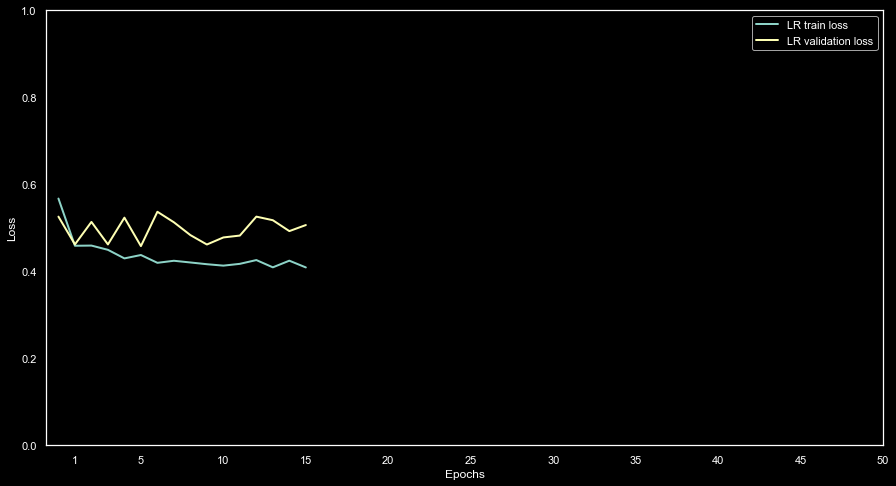

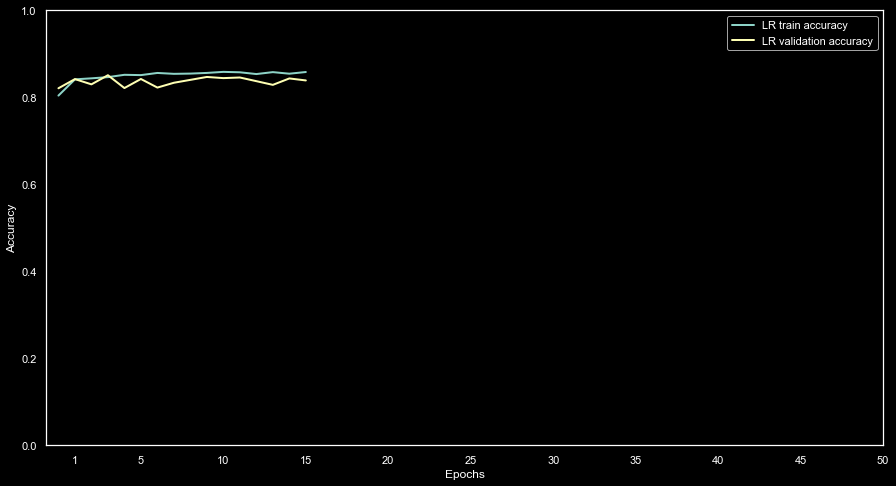

In [149]:
epochs = 50

print("Train Loss     : {0:.5f}".format(mlp_model_hs.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_model_hs.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(baseline_mlp_model_eval[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_model_hs.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_model_hs.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(baseline_mlp_model_eval[1]))

# Plot train and validation error per epoch.
plot_history(hs={'LR': mlp_model_hs}, epochs=epochs, metric='loss')
plot_history(hs={'LR': mlp_model_hs}, epochs=epochs, metric='accuracy')

### Error analysis

In [68]:
mlp_pred_distribution = mlp_model.predict(X_test_mlp)

In [69]:
mlp_pred_labels = [np.argmax(p) for p in mlp_pred_distribution]

In [71]:
misclassified_indices = np.argwhere(y_test != mlp_pred_labels)
print('Number of misclassified:', len(misclassified_indices))

Number of misclassified: 1678


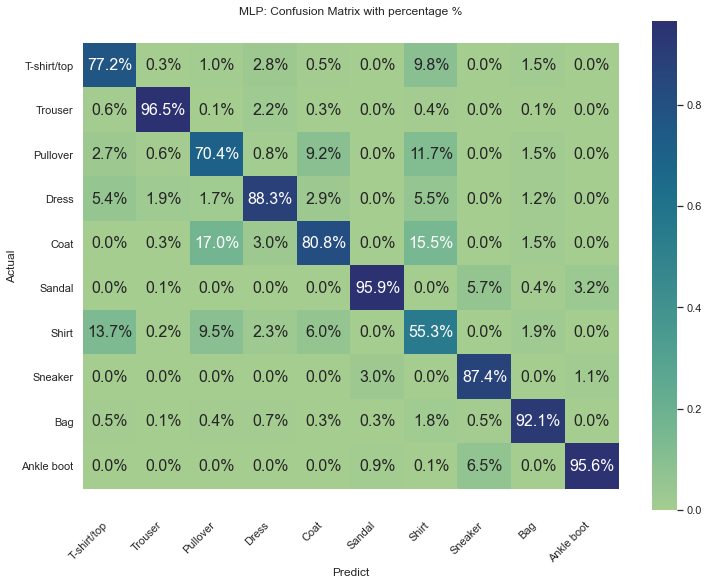

In [115]:
confusion_mlp = confusion_matrix(y_test, mlp_pred_labels)
df_cm_mlp = pd.DataFrame(confusion_mlp, index = [i for i in class_labels], columns = [i for i in class_labels])
plot_confusion_matrix(df_cm_mlp,'MLP')

## Hyperparameter tuning

In [79]:
# def tune_seq_model(hp):
    
#     output_activation = 'softmax'
    
#     hp_activation = hp.Choice('activation', values=('relu', 'tanh', 'selu'), default = 'relu',)
    
#     hp_learning_rate = hp.Choice('learning_rate', values=(1e-2, 1e-3, 1e-4))

#     hp_optimizer = Adam(learning_rate = hp_learning_rate)
    
#     hp_units = hp.Choice(hp.Int('units_1', min_value=32, max_value=512, step=32))
    
#     hp_dropout = hp.Float('dropout',
#                             min_value = 0,
#                             max_value = .5,
#                             step = .1,
#                             default = .2)

#     model = Sequential()
#     model.add(Flatten(input_shape=(28, 28)))
#     model.add(Dense(units=784 , activation=hp_activation))
#     model.add(Dropout(hp_dropout))
#     for i in range(hidden_layers):
#         model.add(Dense(units=hp_units, activation=hp_activation))
#         model.add(Dropout(hp_dropout))
#     model.add(BatchNormalization())
#     model.add(Dense(number_of_classes, activation=output_activation))
    
#     early_stop = EarlyStopping(monitor="val_loss",
#                            mode="min", 
#                            patience=10, 
#                            restore_best_weights=True)
    
#     model.compile(optimizer=hp_optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #balanced problem so accuracy is a good metric
    
#     return model

In [123]:
def tune_mlp_model(hp):
    
    output_activation = 'softmax'
    
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'selu'], default = 'relu',)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    hp_optimizer = Adam(learning_rate = hp_learning_rate)
    
    hp_hidden_layers = hp.Choice('hidden_layers', values=[2, 5, 10])
    
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    
    hp_dropout = hp.Float('dropout',
                            min_value = 0,
                            max_value = .5,
                            step = .1,
                            default = .2)
    
    # First layer: flatten the input, from 28x28 arrays to 1D arrays of 784 pixels.
    inputs = Input(
        shape=(784,),
        name='Input'
    )
    
    x = Dropout(hp_dropout)(inputs) # dropout on the weights.
    
    # Hidden layers
    for i in range(hp_hidden_layers):
        x = Dense(
            units=hp_units,
            kernel_initializer='glorot_uniform',
            activation=hp_activation,
            name='Hidden-{0:d}'.format(i + 1))(x)
        x = Dropout(hp_dropout)(x)
        
    # Last layer: dense, with 10 output neurons and softmax to yield the probabilities of an item belonging to each class.
    output = Dense(
        units=number_of_classes,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=inputs, outputs=output)
    
    # https://stackoverflow.com/questions/58565394/what-is-the-difference-between-sparse-categorical-crossentropy-and-categorical-c
    model.compile(optimizer=hp_optimizer, loss='categorical_crossentropy', metrics=['accuracy']) #balanced problem so accuracy is a good metric
 
    return model


In [129]:
tuner = kt.Hyperband(tune_mlp_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='mlp_dir')

early_stop = EarlyStopping(monitor="val_loss",
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

tuner.search(X_train_mlp, Y_train,  
             epochs=100, 
             validation_data=(X_dev_mlp, Y_dev), 
             callbacks=[early_stop])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 03m 29s]
val_accuracy: 0.8851666450500488

Best val_accuracy So Far: 0.8851666450500488
Total elapsed time: 00h 22m 52s
INFO:tensorflow:Oracle triggered exit


In [131]:
print(f"""
The hyperparameter search is complete:
The optimal number of units in the hidden layers is {best_hps.get('units')}
The optimal number of hidden layers is {best_hps.get('hidden_layers')}
The optimal number of dropout in the first densely-connected layer is {best_hps.get('dropout')}
The optimal activation function for all layers is {best_hps.get('activation')}
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}
""")



The hyperparameter search is complete:
The optimal number of units in the hidden layers is 416
The optimal number of hidden layers is 10
The optimal number of dropout in the first densely-connected layer is 0.0
The optimal activation function for all layers is selu
The optimal learning rate for the optimizer is 0.0001



In [133]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_mlp, Y_train,  
             epochs=50, 
             validation_data=(X_dev_mlp, Y_dev), 
             callbacks=[early_stop])

Epoch 1/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.5053 - accuracy: 0.8191 - val_loss: 0.3817 - val_accuracy: 0.8543
Epoch 2/50
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3849 - accuracy: 0.8572 - val_loss: 0.3581 - val_accuracy: 0.8687
Epoch 3/50
1500/1500 [==============================] - 20s 13ms/step - loss: 0.3526 - accuracy: 0.8699 - val_loss: 0.3521 - val_accuracy: 0.8716
Epoch 4/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3259 - accuracy: 0.8788 - val_loss: 0.3665 - val_accuracy: 0.8672
Epoch 5/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.3083 - accuracy: 0.8846 - val_loss: 0.3419 - val_accuracy: 0.8776
Epoch 6/50
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2877 - accuracy: 0.8931 - val_loss: 0.4105 - val_accuracy: 0.8594
Epoch 7/50
1500/1500 [==============================] - 21s 14ms/step - loss: 0.2719 - accuracy: 0.8973 - val_loss: 0.3563 -

## Evaluation

In [134]:
eval_result = best_model.evaluate(X_test_mlp, Y_test, verbose=1)
clean_up(model=best_model)

313/313 [==============================] - 2s 5ms/step - loss: 0.3425 - accuracy: 0.8806


Train Loss     : 0.14624
Validation Loss: 0.40471
Test Loss      : 0.39963
---
Train Accuracy     : 0.94327
Validation Accuracy: 0.88992
Test Accuracy      : 0.86230



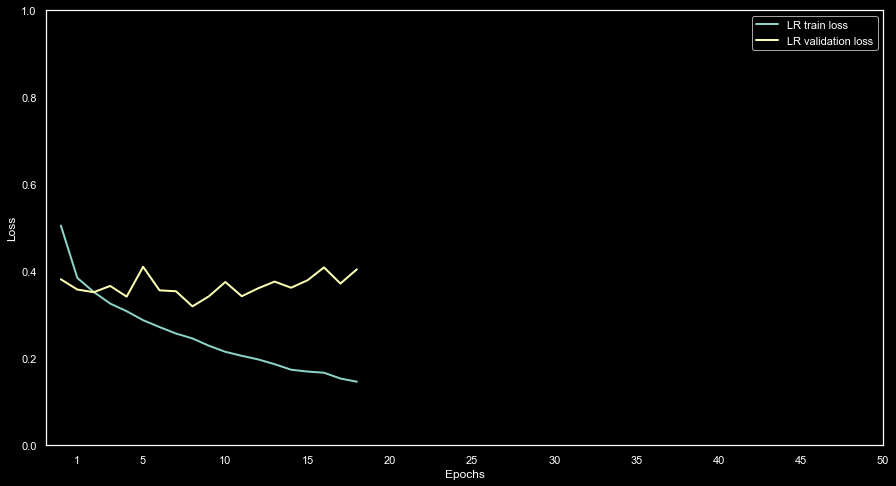

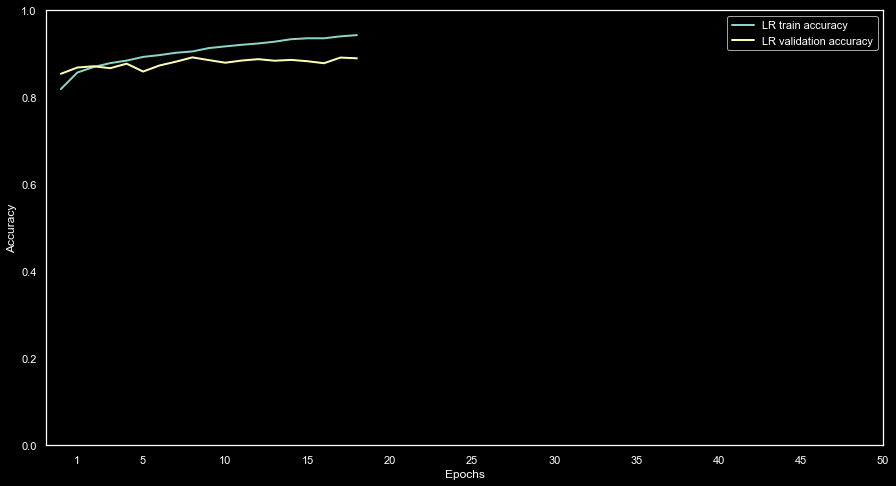

In [150]:
epochs = 50

print("Train Loss     : {0:.5f}".format(history.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(eval_result[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(eval_result[1]))

# Plot train and validation error per epoch.
plot_history(hs={'LR': history}, epochs=epochs, metric='loss')
plot_history(hs={'LR': history}, epochs=epochs, metric='accuracy')

### Error analysis

In [141]:
hypermodel_pred_distribution = best_model.predict(X_test_mlp)

In [142]:
hypermodel_pred_labels = [np.argmax(p) for p in hypermodel_pred_distribution]

In [143]:
misclassified_indices = np.argwhere(y_test != hypermodel_pred_labels)
print('Number of misclassified:', len(misclassified_indices))

Number of misclassified: 1194


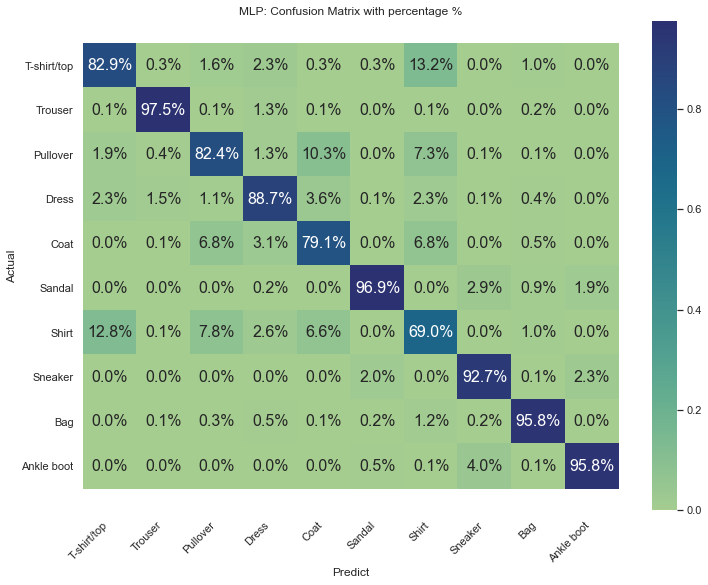

In [148]:
confusion_mlp = confusion_matrix(y_test, hypermodel_pred_labels)
df_cm_mlp = pd.DataFrame(confusion_mlp, index = [i for i in class_labels], columns = [i for i in class_labels])
plot_confusion_matrix(df_cm_mlp,'MLP')